# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm 
from matplotlib.colors import from_levels_and_colors
%matplotlib inline
from IPython.display import display

import scipy.stats as stats
from scipy.stats import ttest_ind, f_oneway, chi2_contingency
from scipy.stats import chi2
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.outliers_influence import variance_inflation_factor
import math

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.mosaicplot import mosaic

import warnings
warnings.filterwarnings('ignore')

# Cleaning the Data

In [2]:
# Read data
churn_df = pd.read_csv('/Users/williamjowens/Desktop/Datasets/customer_churn.csv')
churn_df.head()

,Call Failure,Complains,Subscription Length,Charge Amount,Seconds of Use,Frequency of use,Frequency of SMS,Distinct Called Numbers,Age Group,Tariff Plan,Status,Age,Customer Value,Churn
0,8,0,38,0,4370,71,5,17,3,1,1,30,197.640,0
1,0,0,39,0,318,5,7,4,2,1,2,25,46.035,0
2,10,0,37,0,2453,60,359,24,3,1,1,30,1536.520,0
3,10,0,38,0,4198,66,1,35,1,1,1,15,240.020,0
4,3,0,38,0,2393,58,2,33,1,1,1,15,145.805,0


In [3]:
# Rename index column
churn_df.reset_index(inplace=True)
churn_df.rename(columns={'index': 'customer'}, inplace=True)
churn_df.set_index('customer', inplace=True)
churn_df.head()

,Call Failure,Complains,Subscription Length,Charge Amount,Seconds of Use,Frequency of use,Frequency of SMS,Distinct Called Numbers,Age Group,Tariff Plan,Status,Age,Customer Value,Churn
customer,,,,,,,,,,,,,,
0,8,0,38,0,4370,71,5,17,3,1,1,30,197.640,0
1,0,0,39,0,318,5,7,4,2,1,2,25,46.035,0
2,10,0,37,0,2453,60,359,24,3,1,1,30,1536.520,0
3,10,0,38,0,4198,66,1,35,1,1,1,15,240.020,0
4,3,0,38,0,2393,58,2,33,1,1,1,15,145.805,0


In [4]:
# Rename variables
dict = {
    'Call  Failure': 'call_failures',
    'Complains': 'complaint',
    'Subscription  Length': 'months_subscribed',
    'Charge  Amount': 'charge_amt',
    'Seconds of Use': 'total_call_secs',
    'Frequency of use': 'total_calls',
    'Frequency of SMS': 'total_texts',
    'Distinct Called Numbers': 'distinct_calls',
    'Age Group': 'age_group',
    'Tariff Plan': 'tariff_plan',
    'Status': 'active_status',
    'Age': 'age',
    'Customer Value': 'customer_value',
    'Churn': 'churn'
}

churn_df.rename(dict, axis=1, inplace=True)
churn_df.head()

,call_failures,complaint,months_subscribed,charge_amt,total_call_secs,total_calls,total_texts,distinct_calls,age_group,tariff_plan,active_status,age,customer_value,churn
customer,,,,,,,,,,,,,,
0,8,0,38,0,4370,71,5,17,3,1,1,30,197.640,0
1,0,0,39,0,318,5,7,4,2,1,2,25,46.035,0
2,10,0,37,0,2453,60,359,24,3,1,1,30,1536.520,0
3,10,0,38,0,4198,66,1,35,1,1,1,15,240.020,0
4,3,0,38,0,2393,58,2,33,1,1,1,15,145.805,0


In [5]:
# Change numeric values: 0 = pay as you go, 1 = contractual & 0 = non-active, 1 = active
churn_df['tariff_plan'] = churn_df['tariff_plan'].replace({1: 0, 2: 1})
churn_df['active_status'] = churn_df['active_status'].replace({2: 0, 1: 1})
churn_df[['tariff_plan', 'active_status']].head()

,tariff_plan,active_status
customer,,
0,0,1
1,0,0
2,0,1
3,0,1
4,0,1


In [6]:
# Check df
churn_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3150 entries, 0 to 3149
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   call_failures      3150 non-null   int64  
 1   complaint          3150 non-null   int64  
 2   months_subscribed  3150 non-null   int64  
 3   charge_amt         3150 non-null   int64  
 4   total_call_secs    3150 non-null   int64  
 5   total_calls        3150 non-null   int64  
 6   total_texts        3150 non-null   int64  
 7   distinct_calls     3150 non-null   int64  
 8   age_group          3150 non-null   int64  
 9   tariff_plan        3150 non-null   int64  
 10  active_status      3150 non-null   int64  
 11  age                3150 non-null   int64  
 12  customer_value     3150 non-null   float64
 13  churn              3150 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 369.1 KB


In [7]:
# Unique values
churn_df.nunique()

call_failures          37
complaint               2
months_subscribed      45
charge_amt             11
total_call_secs      1756
total_calls           242
total_texts           405
distinct_calls         92
age_group               5
tariff_plan             2
active_status           2
age                     5
customer_value       2654
churn                   2
dtype: int64

In [8]:
# Remove age
churn_df = churn_df.drop(columns=['age'])

In [9]:
# Save cleaned dataset
clean_df = churn_df
clean_df.to_csv('/Users/williamjowens/Desktop/Datasets/clean_df.csv', index=False)

# Exploratory Data Analysis

## Descriptive Statistics

In [10]:
# Numeric variables
numeric = churn_df[['call_failures', 'months_subscribed', 'total_call_secs', 'total_calls', 'total_texts', 'distinct_calls', 'customer_value']]
numeric_X = numeric.drop(columns=['customer_value'])

# Ordinal variables
ordinal = churn_df[['charge_amt', 'age_group']]

# Binary variables
binary = churn_df[['complaint', 'tariff_plan', 'active_status', 'churn']]
binary_X = binary.drop(columns=['churn'])

# All categorical
category = pd.concat([ordinal, binary], axis=1)
category_X = category.drop(columns=['churn'])

In [11]:
# Descriptive stats
df_numeric = numeric.describe()

# Range
df_range = (numeric.max() - numeric.min()).to_frame().T
df_range.index = ['range']

# Skew
df_skew = numeric.skew().to_frame().T
df_skew.index = ['skew']

# Combine
df_numeric_plus = pd.concat([df_numeric, df_range, df_skew], axis=0)
df_numeric_plus.T

,count,mean,std,min,25%,50%,75%,max,range,skew
call_failures,3150.0,7.627937,7.263886,0.0,1.00000,6.00,12.00000,36.00,36.00,1.089752
months_subscribed,3150.0,32.541905,8.573482,3.0,30.00000,35.00,38.00000,47.00,44.00,-1.300015
total_call_secs,3150.0,4472.459683,4197.908687,0.0,1391.25000,2990.00,6478.25000,17090.00,17090.00,1.321943
total_calls,3150.0,69.460635,57.413308,0.0,27.00000,54.00,95.00000,255.00,255.00,1.144166
total_texts,3150.0,73.174921,112.237560,0.0,6.00000,21.00,87.00000,522.00,522.00,1.974142
distinct_calls,3150.0,23.509841,17.217337,0.0,10.00000,21.00,34.00000,97.00,97.00,1.029402
customer_value,3150.0,470.972916,517.015433,0.0,113.80125,228.48,788.38875,2165.28,2165.28,1.427292


In [12]:
# Ordinal descriptive stats
df_ordinal = ordinal.astype('object').describe()
df_ordinal

,charge_amt,age_group
count,3150,3150
unique,11,5
top,0,3
freq,1768,1425


In [13]:
# Binary descriptive stats
df_binary = binary.astype('object').describe()
df_binary

,complaint,tariff_plan,active_status,churn
count,3150,3150,3150,3150
unique,2,2,2,2
top,0,0,1,0
freq,2909,2905,2368,2655


In [14]:
# Target variable value counts
churn_df['churn'].value_counts()

0    2655
1     495
Name: churn, dtype: int64

## Visual Analysis

### Histograms

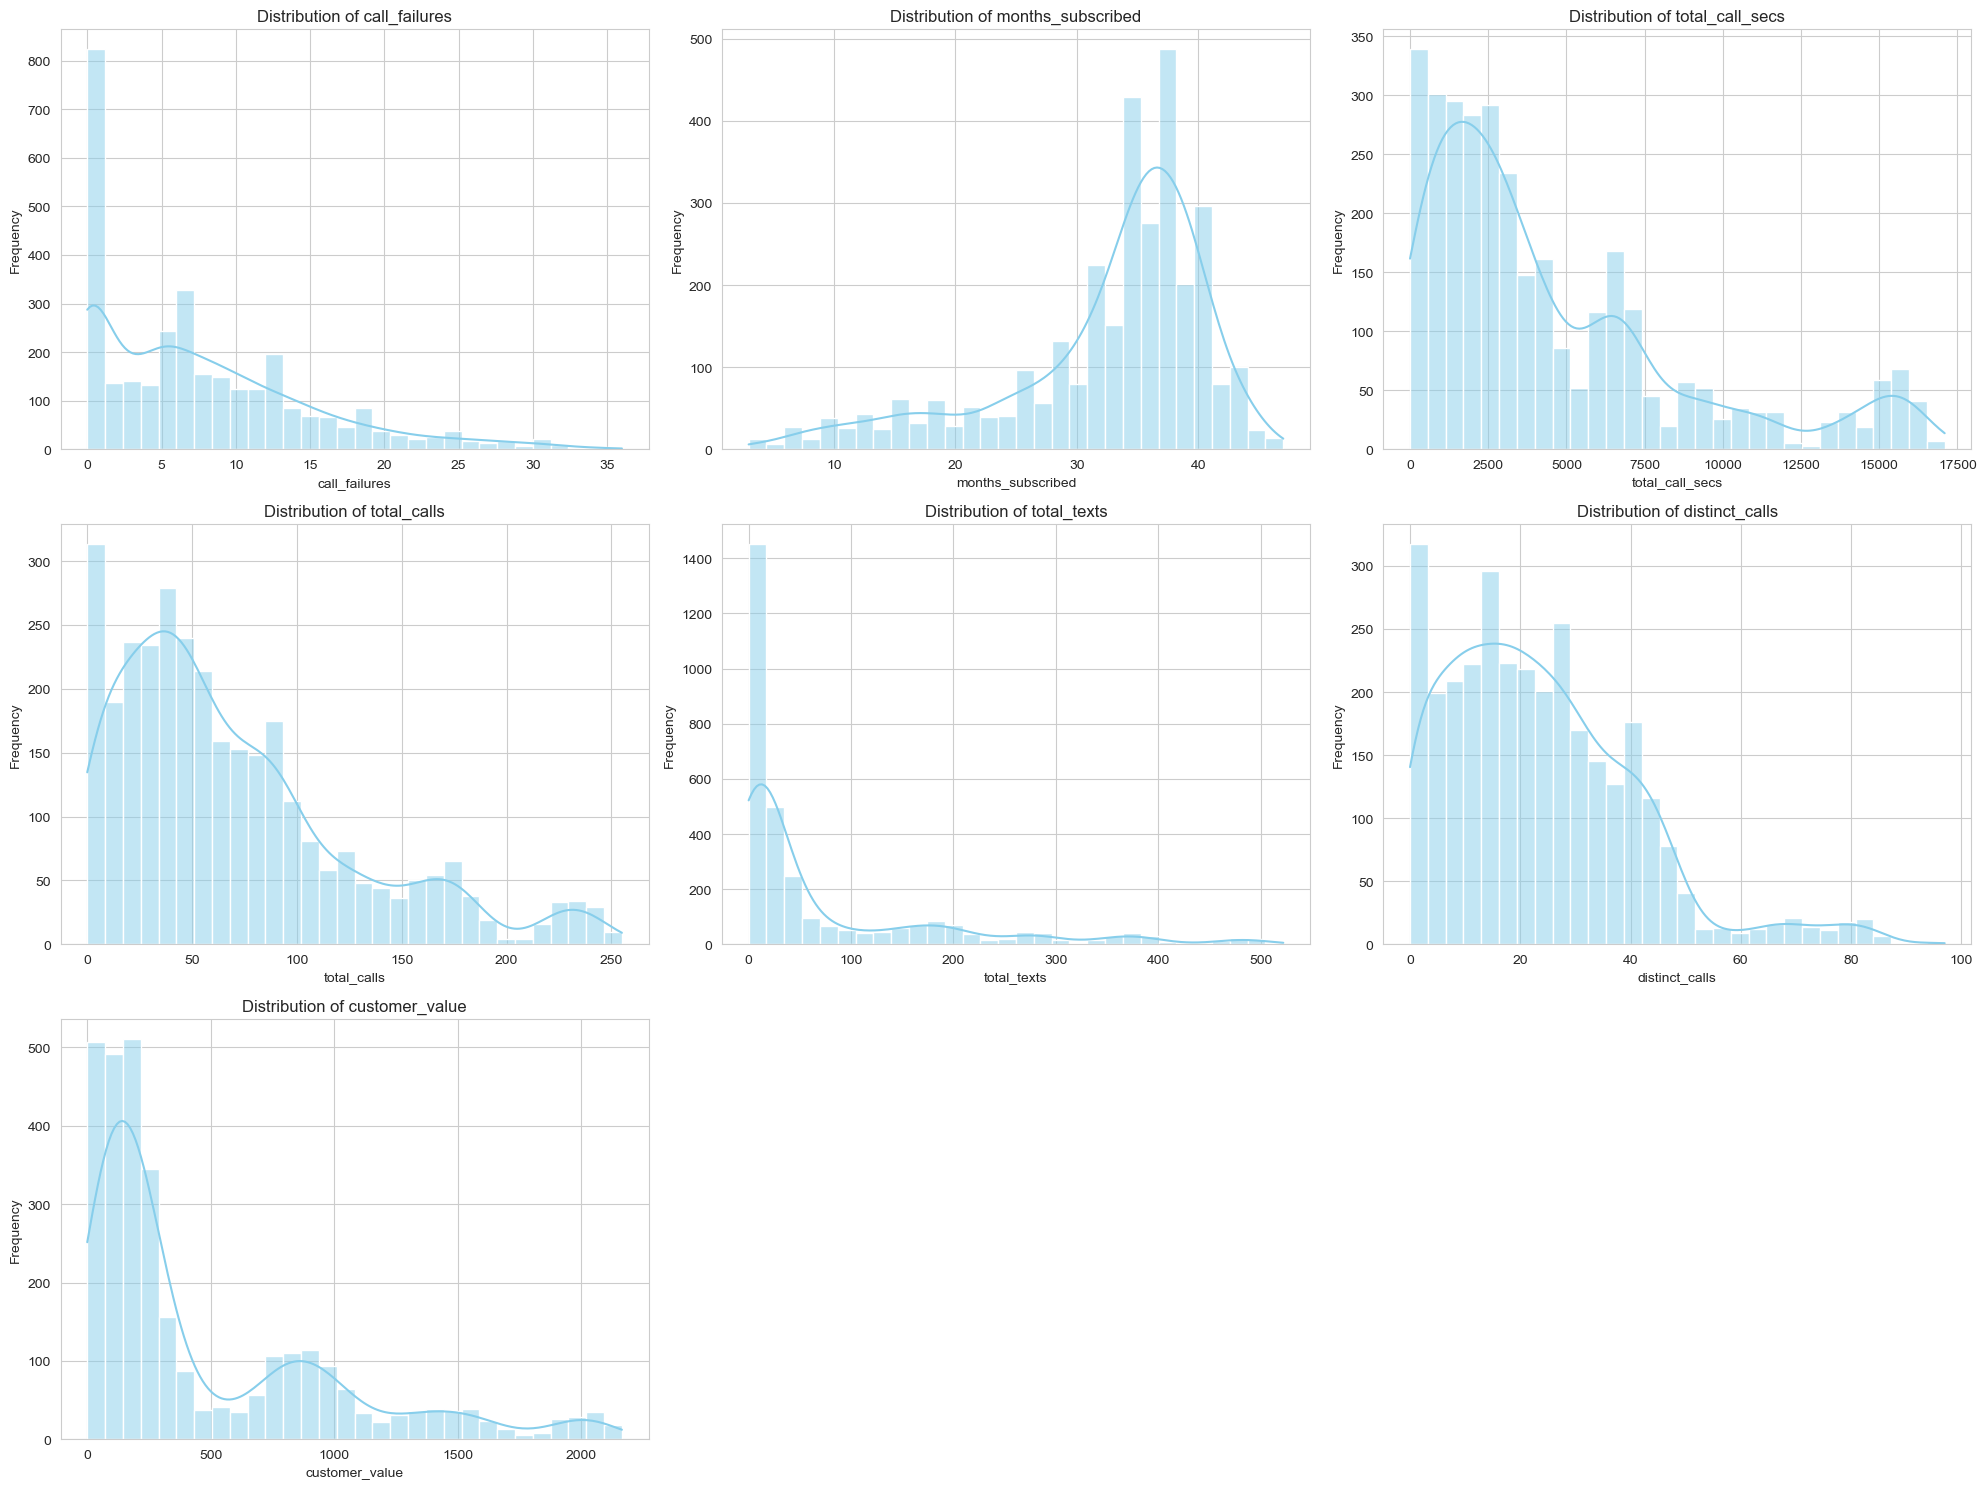

In [15]:
# Numeric histograms
sns.set_style('whitegrid')

plt.figure(figsize=(20, 15))

for i, var in enumerate(numeric.columns):
    plt.subplot(3, 3, i+1)
    sns.histplot(data=churn_df, x=var, bins=30, kde=True, color='skyblue')
    plt.title(f'Distribution of {var}')
    plt.xlabel(var)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

### Scatterplots

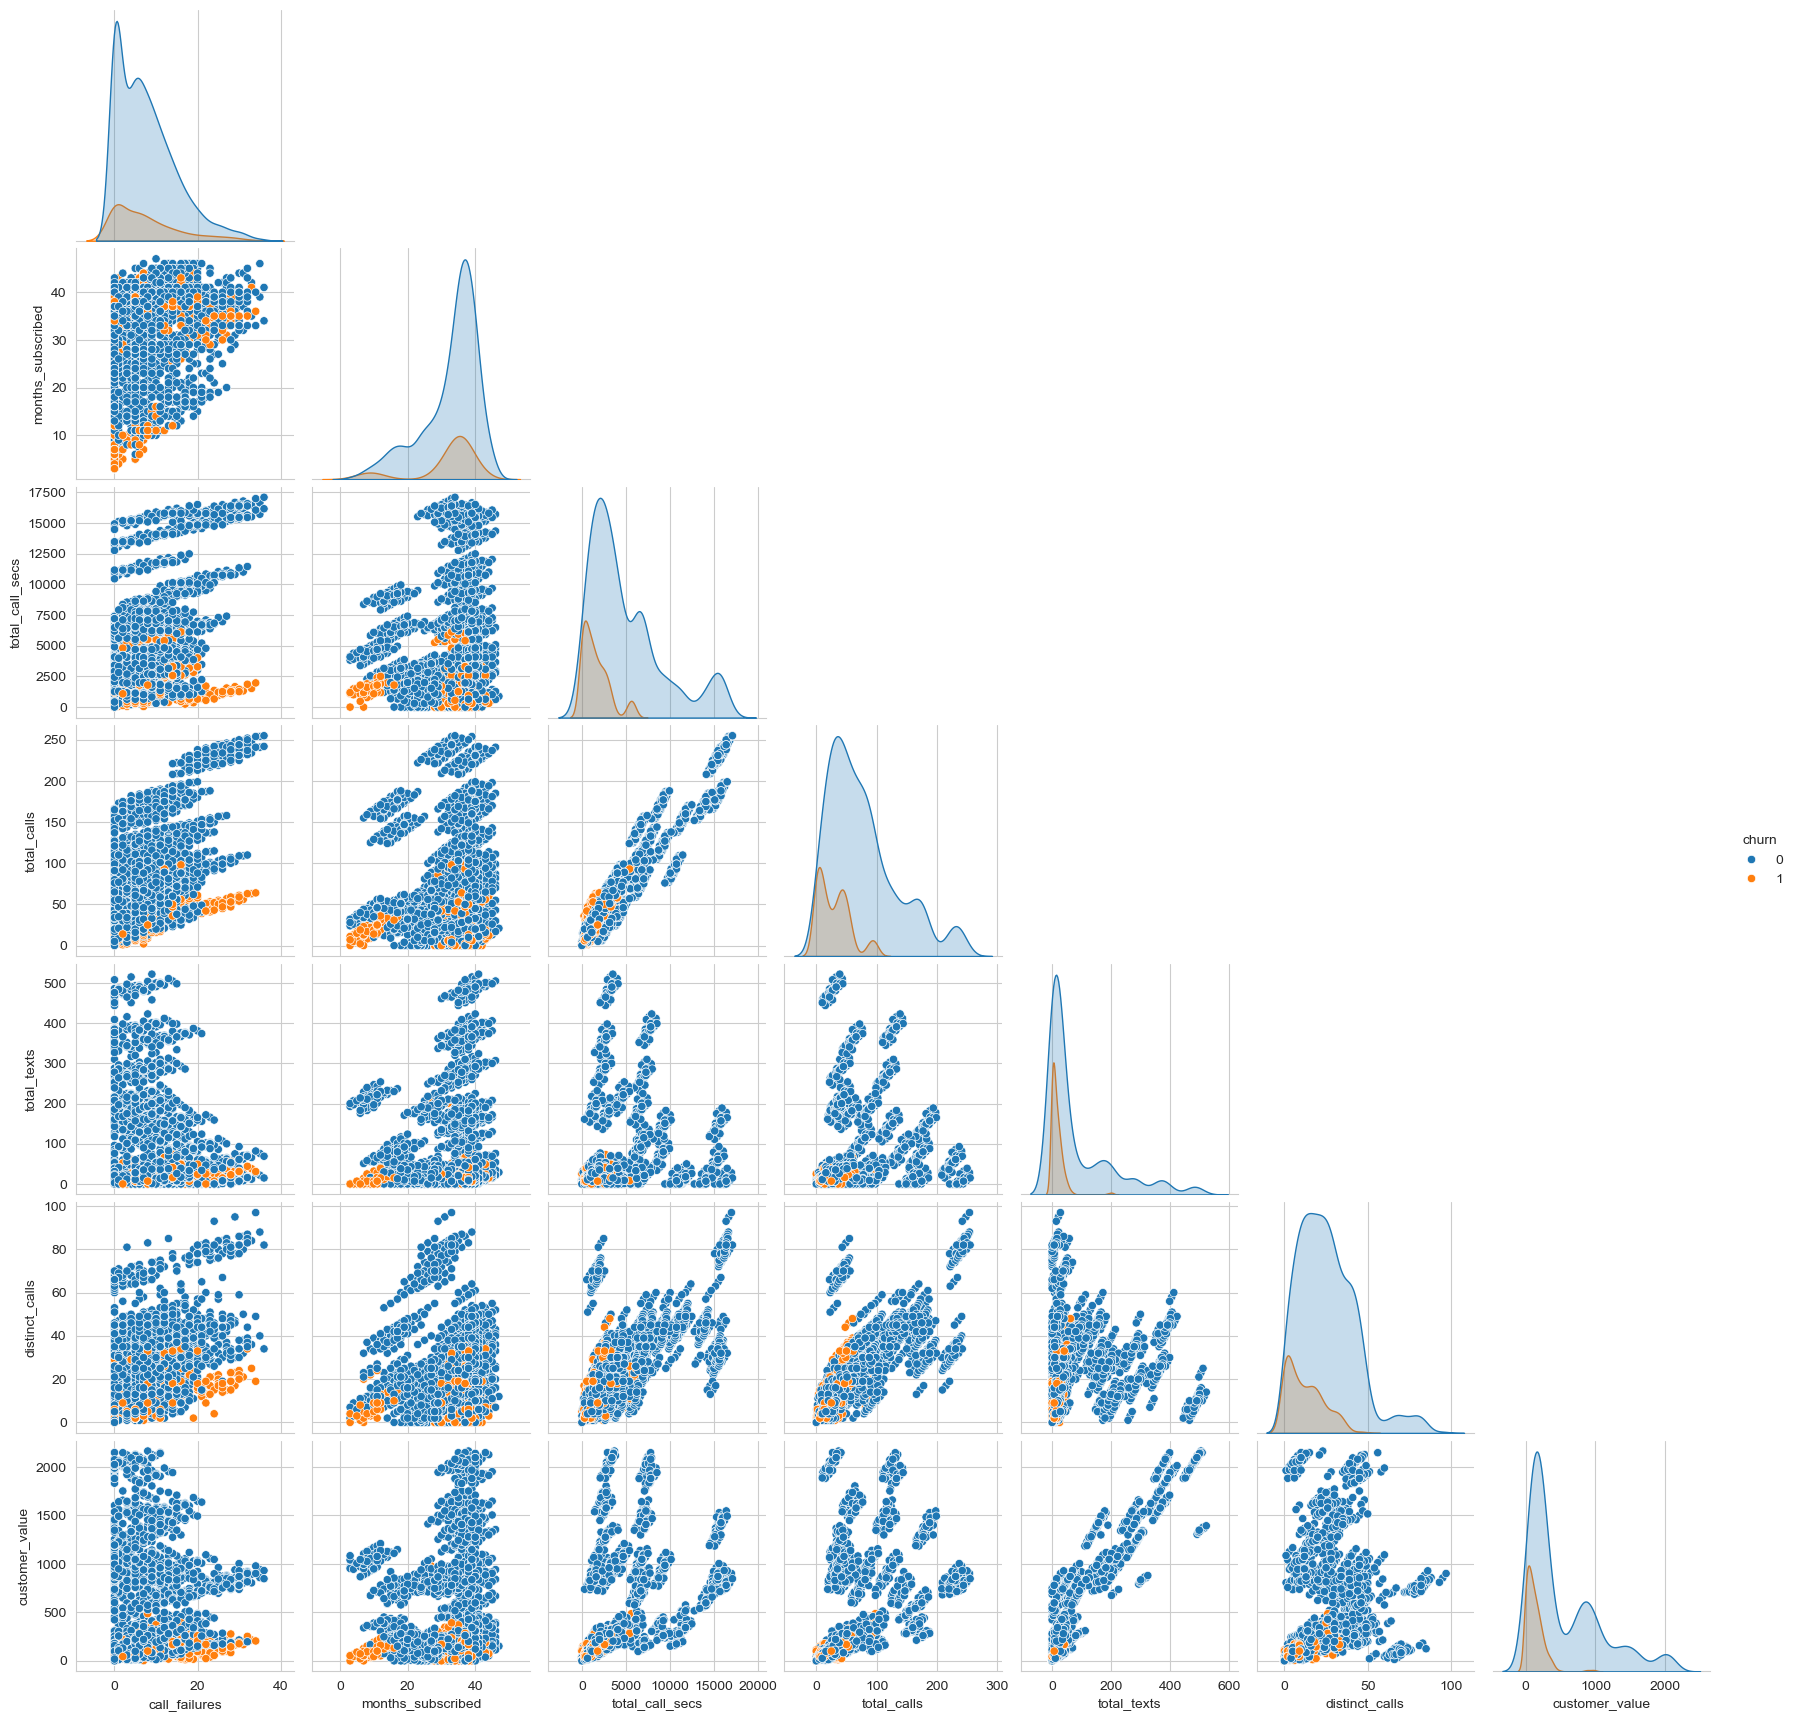

In [16]:
# Numeric scatterplots
scatterplots = sns.pairplot(churn_df, vars=numeric.columns, hue='churn', corner=True)
scatterplots

### Countplots

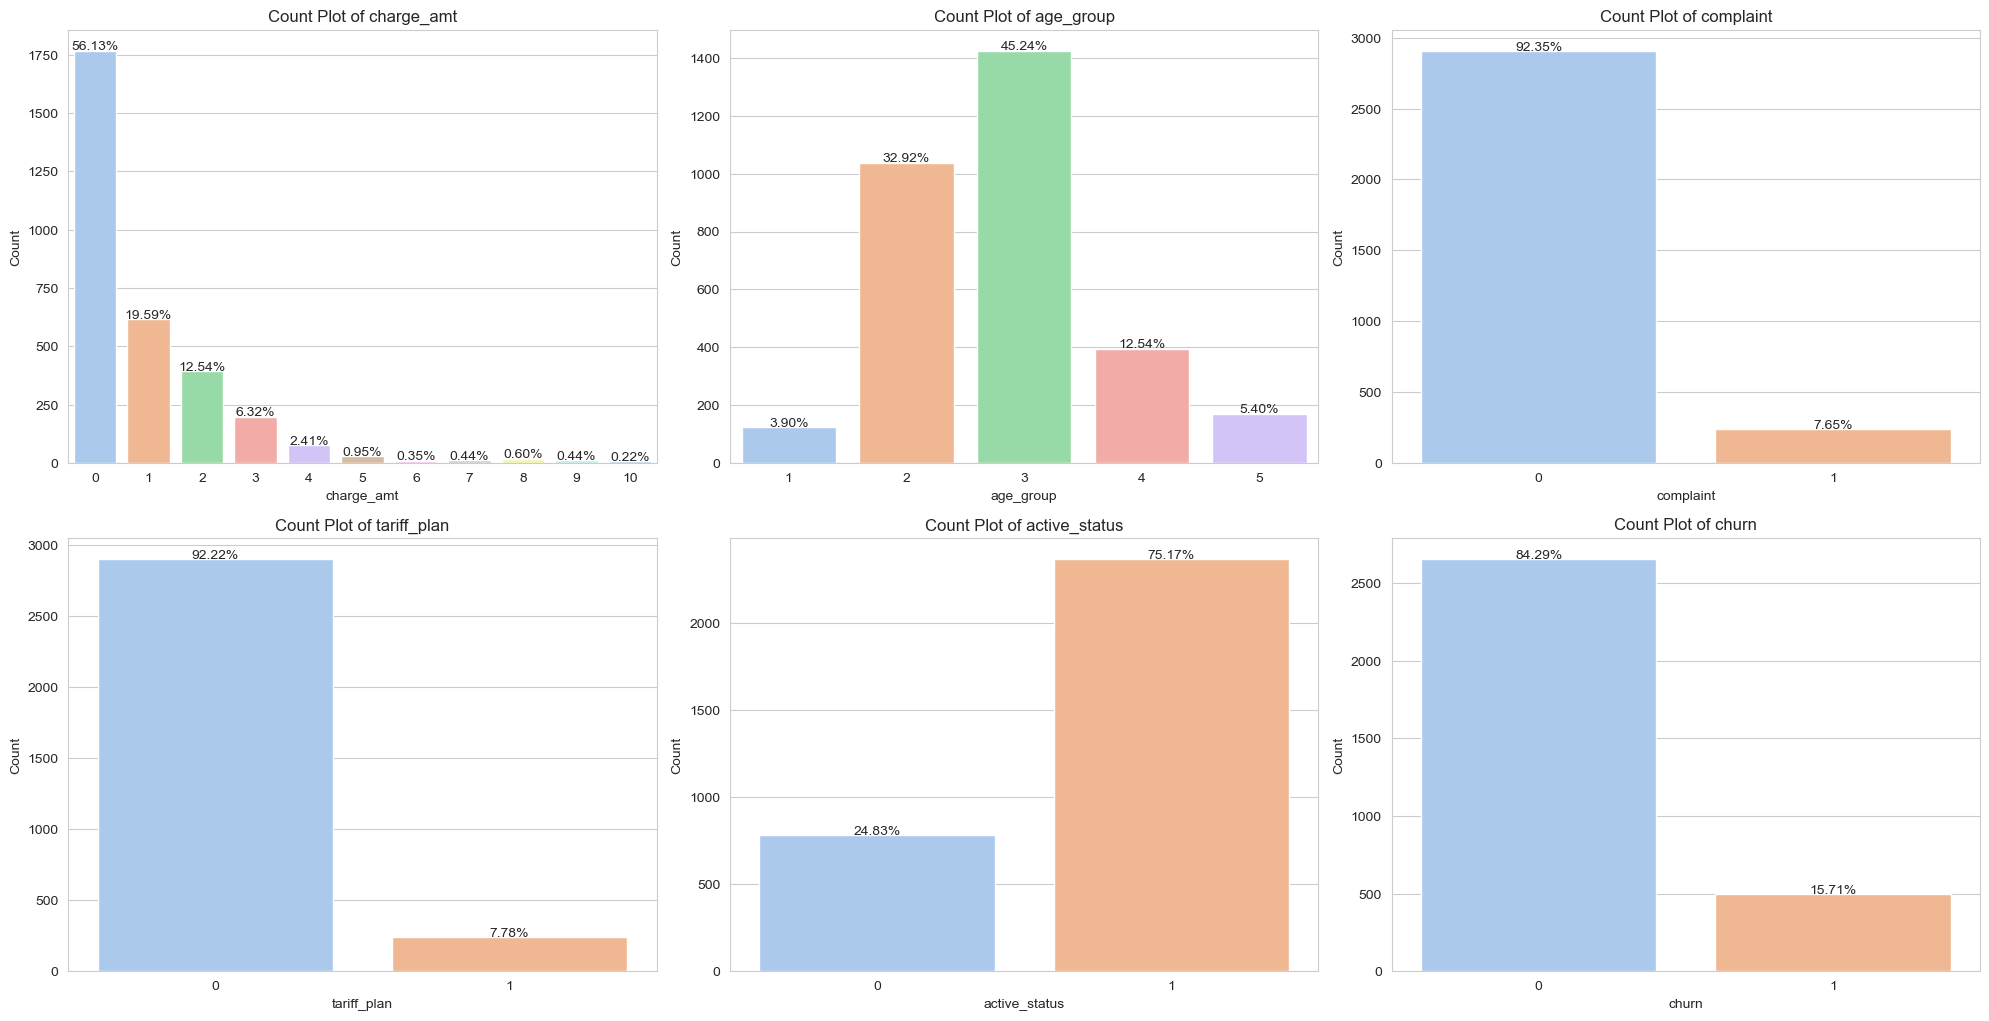

In [17]:
# Categorical countplots with percentages
plt.figure(figsize=(20, 15))

for i, var in enumerate(category.columns):
    plt.subplot(3, 3, i+1)
    ax = sns.countplot(data=churn_df, x=var, palette='pastel')  # Assigning the plot to ax
    
    # Getting the total count for calculating percentages
    total = len(churn_df)
    
    # Annotating each bar with the percentage
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2.,
                height + 3,
                '{:1.2f}%'.format(100 * height / total),
                ha="center") 
    
    plt.title(f'Count Plot of {var}')
    plt.xlabel(var)
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

### Boxplots

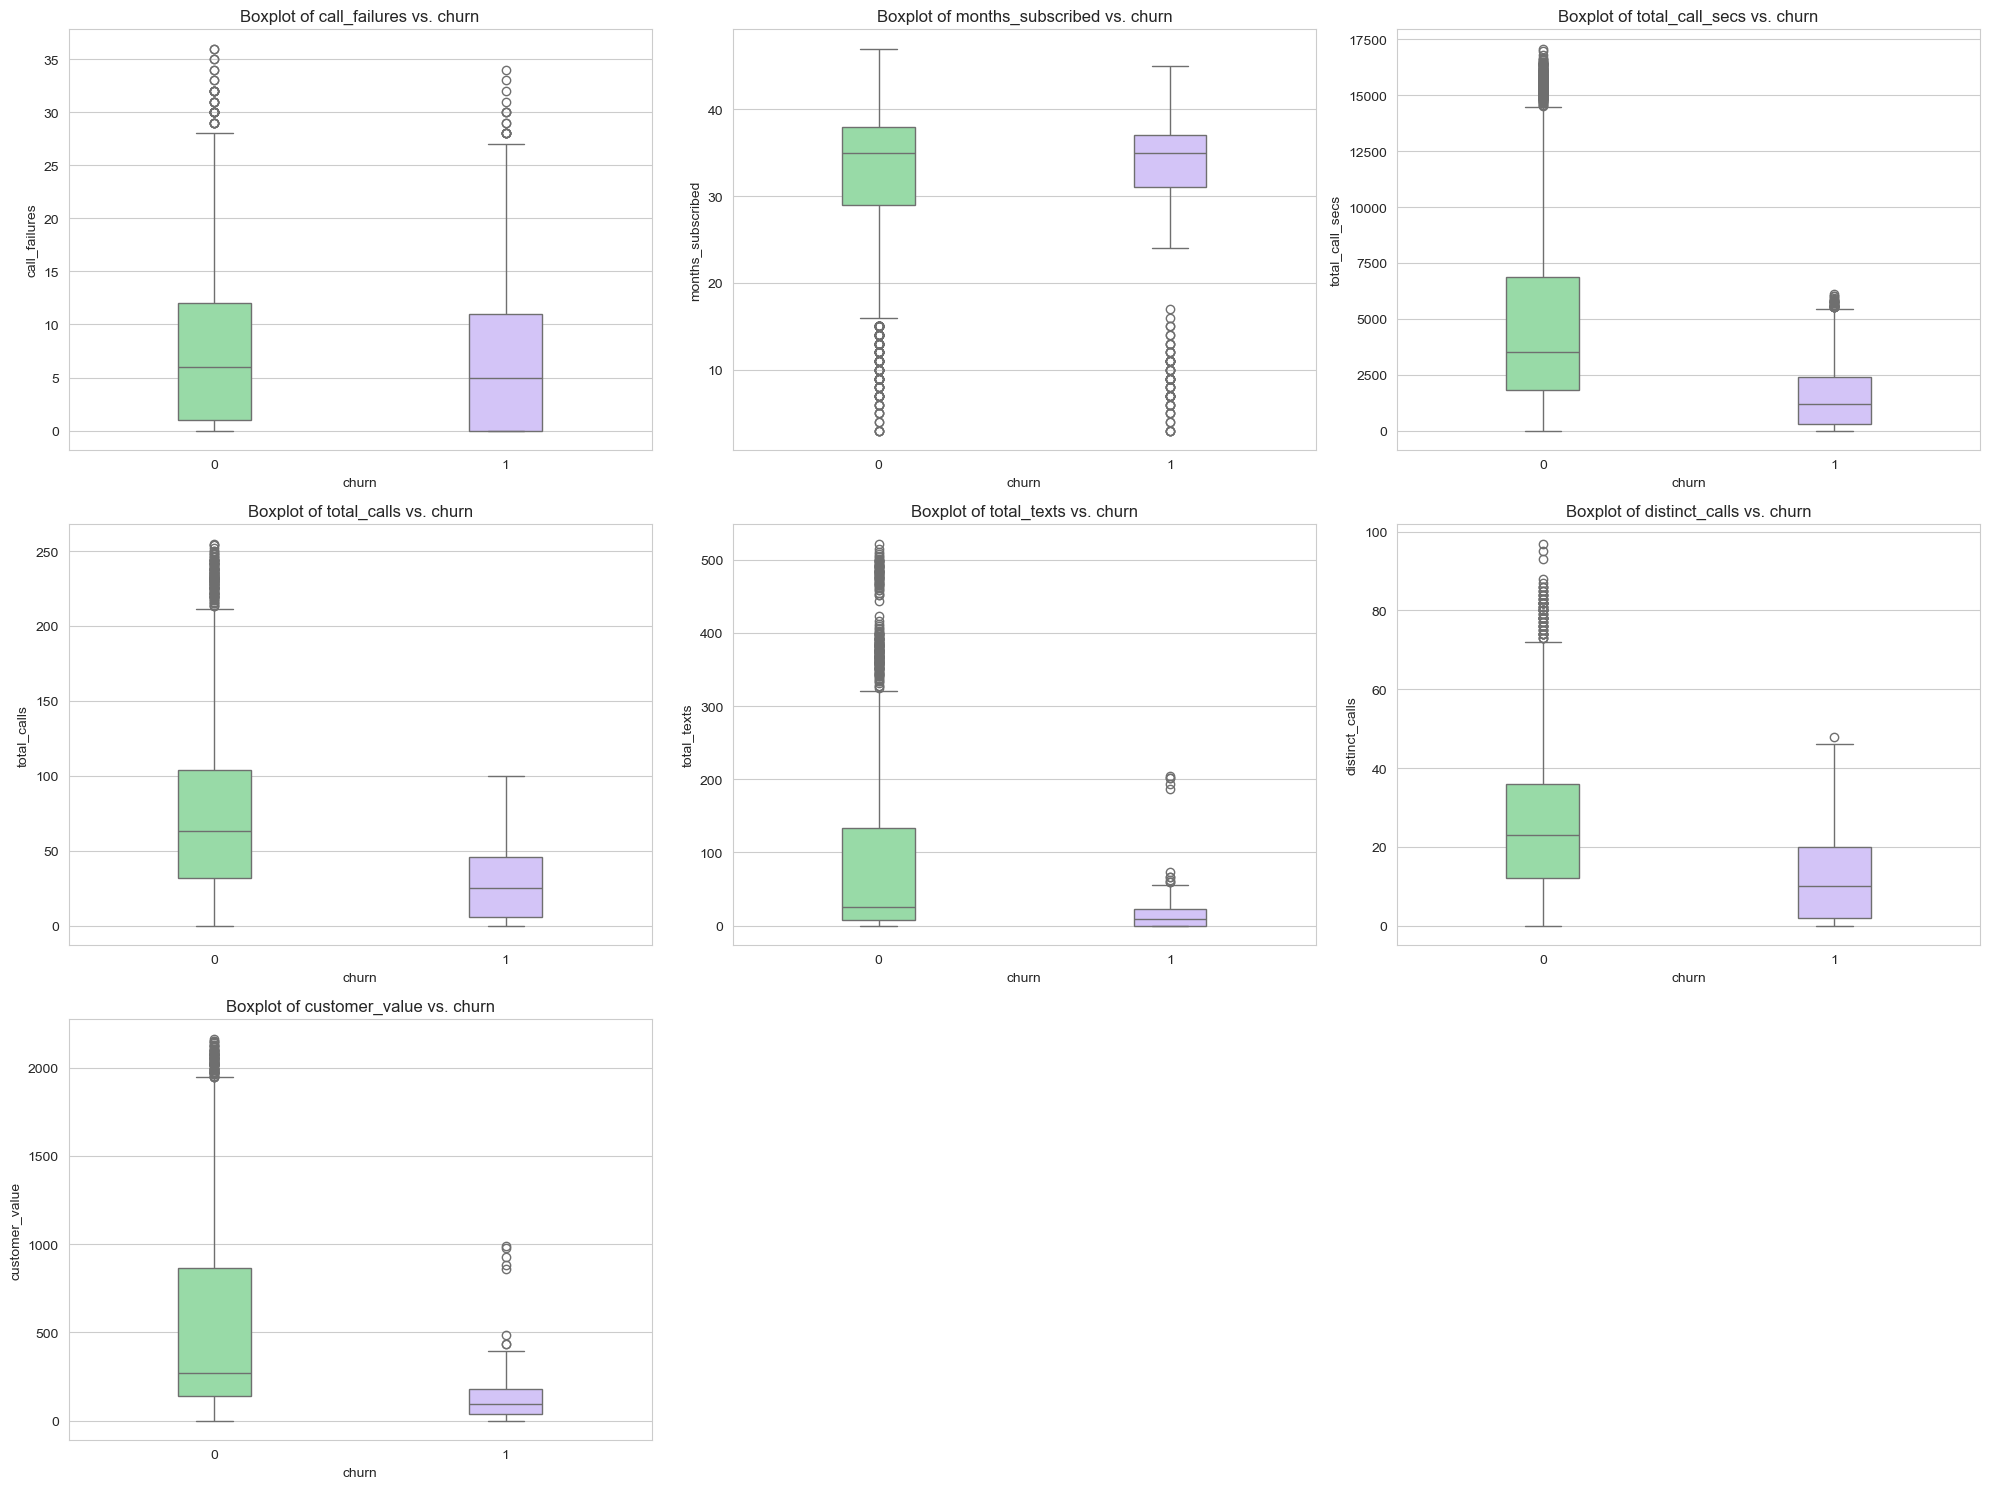

In [18]:
# Numeric vs. target boxplots
plt.figure(figsize=(20, 15))

for i, var in enumerate(numeric.columns):
    plt.subplot(3, 3, i+1)
    sns.boxplot(data=churn_df, x='churn', y=var, width=0.25,
                palette=[sns.color_palette('pastel')[2], sns.color_palette('pastel')[4]])
    plt.title(f'Boxplot of {var} vs. churn')
    plt.xlabel('churn')
    plt.ylabel(var)

plt.tight_layout()
plt.show()

### Violinplots

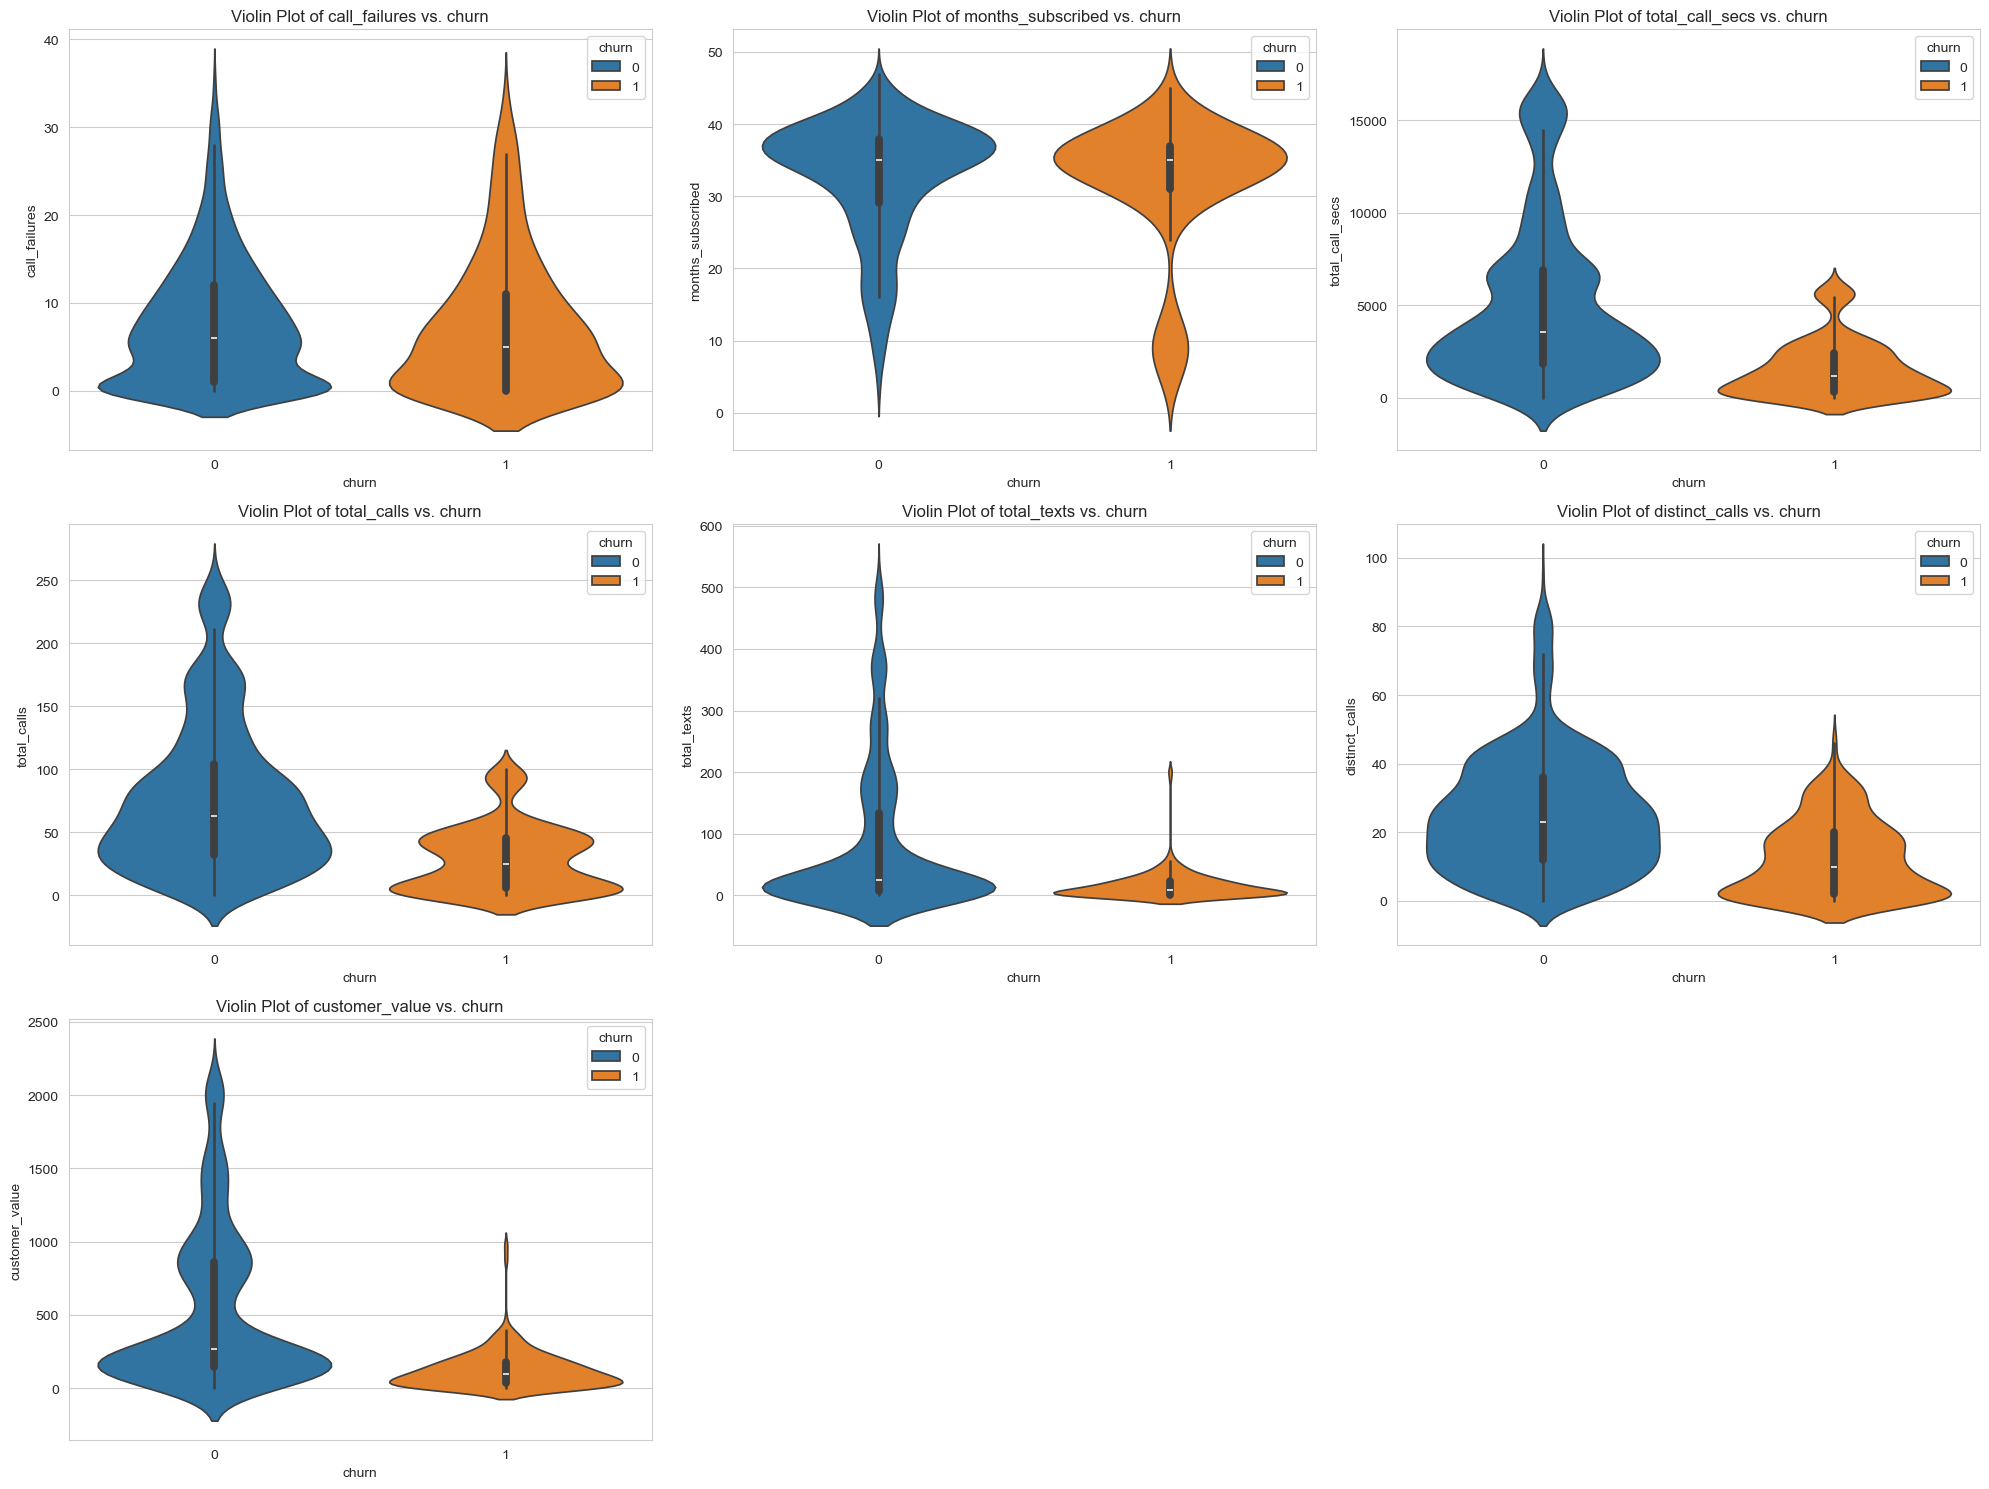

In [19]:
# Numeric vs. target violinplots
plt.figure(figsize=(20, 15))

for i, var in enumerate(numeric.columns):
    plt.subplot(3, 3, i+1)
    sns.violinplot(data=churn_df, x='churn', y=var, hue='churn')
    plt.title(f'Violin Plot of {var} vs. churn')
    plt.xlabel('churn')
    plt.ylabel(var)

plt.tight_layout()
plt.show()

## Correlational Analysis

In [20]:
# Correlations
corr_df = numeric.corr()
corr_df

,call_failures,months_subscribed,total_call_secs,total_calls,total_texts,distinct_calls,customer_value
call_failures,1.000000,0.169737,0.501607,0.573349,-0.022282,0.504058,0.121225
months_subscribed,0.169737,1.000000,0.124618,0.106534,0.076318,0.092009,0.109565
total_call_secs,0.501607,0.124618,1.000000,0.946489,0.102123,0.676536,0.415087
total_calls,0.573349,0.106534,0.946489,1.000000,0.100019,0.736114,0.401572
total_texts,-0.022282,0.076318,0.102123,0.100019,1.000000,0.079650,0.924877
distinct_calls,0.504058,0.092009,0.676536,0.736114,0.079650,1.000000,0.284807
customer_value,0.121225,0.109565,0.415087,0.401572,0.924877,0.284807,1.000000


In [21]:
# Correlations with customer_value
corr_cv = numeric_X.corrwith(churn_df['customer_value']).sort_values(ascending=False)
corr_cv

total_texts          0.924877
total_call_secs      0.415087
total_calls          0.401572
distinct_calls       0.284807
call_failures        0.121225
months_subscribed    0.109565
dtype: float64

### Heatmap

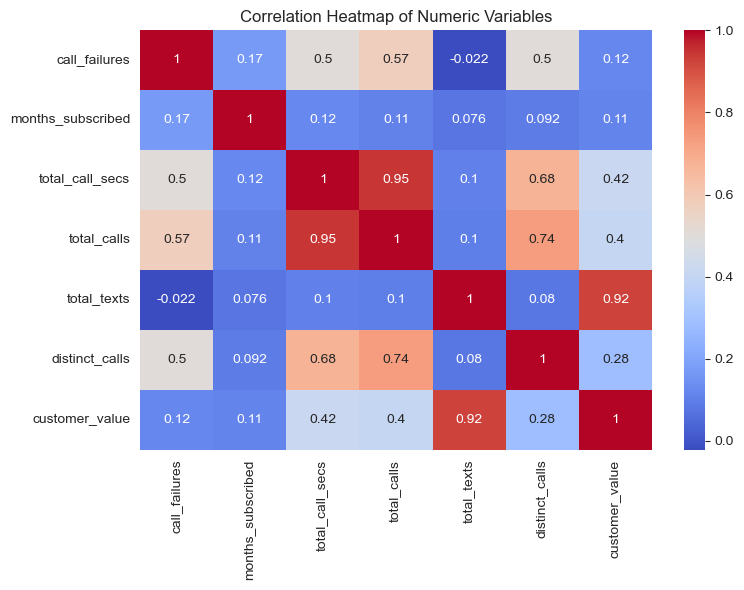

In [22]:
# Correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(data=corr_df, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Numeric Variables')
plt.tight_layout()
plt.show()

### Variance Inflation Factor

In [23]:
# Check VIF
vif_data = pd.DataFrame()
vif_data["variable"] = churn_df.columns
vif_data["VIF"] = [variance_inflation_factor(churn_df.values, i) for i in range(len(churn_df.columns))]
vif_data = vif_data.sort_values(by=['VIF'], ascending=False)
vif_data

,variable,VIF
11,customer_value,84.186721
6,total_texts,51.713965
5,total_calls,46.729608
4,total_call_secs,45.473008
8,age_group,13.048888
2,months_subscribed,11.319083
7,distinct_calls,6.885422
10,active_status,6.438831
0,call_failures,6.107124
3,charge_amt,4.206752


## Categorical Analysis

### Contingency Tables

In [24]:
# Contingency tables for categorical variables vs. churn
for i, var in enumerate(category_X.columns):
    # Number of unique categories in the variable
    num_categories = len(np.unique(category_X[var]))
    
    # Skip the variable if it does not have exactly 2 unique categories
    if num_categories != 2:
        continue
    
    # Create a contingency table
    contingency_table = pd.crosstab(category['churn'], category_X[var])
    
    # Perform the chi-squared test on the contingency table
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    
    # Display the contingency table and test results
    print(f'Contingency Table for {var} by churn:\n')
    display(contingency_table)
    print(f'\nChi2 statistic: {chi2:.2f}, p-value: {p:.4f}\n')
    print('-' * 50)
    print('-' * 50)
    print('\n')

Contingency Table for complaint by churn:



complaint,0,1
churn,,
0,2614,41
1,295,200



Chi2 statistic: 886.21, p-value: 0.0000

--------------------------------------------------
--------------------------------------------------


Contingency Table for tariff_plan by churn:



tariff_plan,0,1
churn,,
0,2416,239
1,489,6



Chi2 statistic: 34.22, p-value: 0.0000

--------------------------------------------------
--------------------------------------------------


Contingency Table for active_status by churn:



active_status,0,1
churn,,
0,412,2243
1,370,125



Chi2 statistic: 781.11, p-value: 0.0000

--------------------------------------------------
--------------------------------------------------




### Mosaic Plots

<Figure size 2000x1500 with 0 Axes>

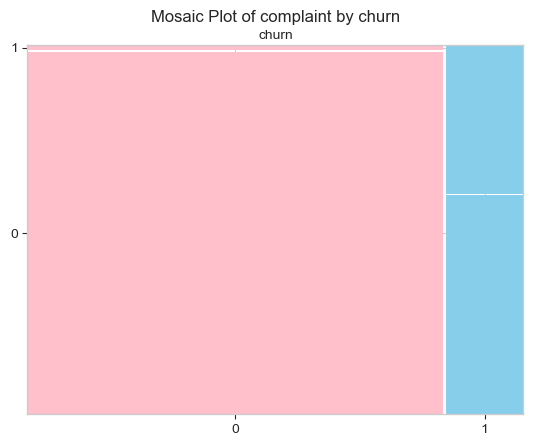

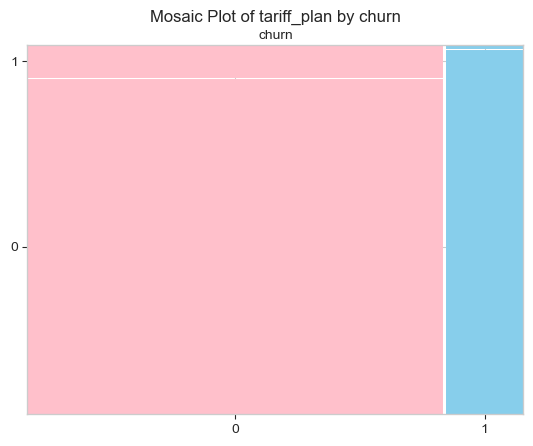

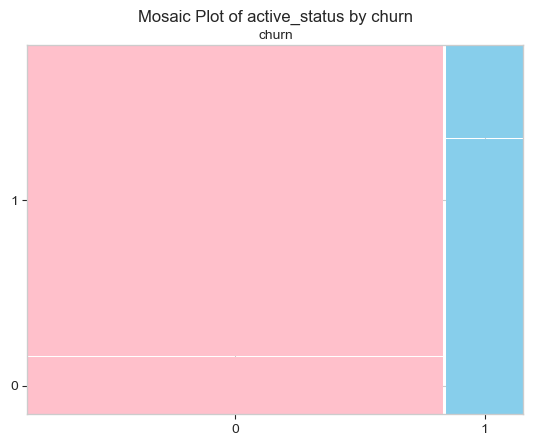

In [25]:
# Mosaic plots
plt.figure(figsize=(20, 15))

for i, var in enumerate(category_X.columns):
    # Skip the variable if it does not have exactly 2 unique categories
    if category_X[var].nunique() != 2:
        continue
    
    category[var] = pd.Categorical(category[var], categories=sorted(category[var].unique()), ordered=True)
    
    mosaic(category, ['churn', var], title=f'Mosaic Plot of {var} by churn', 
                                     labelizer=lambda k: '', 
                                     properties=lambda key: {'facecolor': 'pink' if key[0] == '0' else 'skyblue', 
                                                             'edgecolor': 'white', 'linewidth': 0.03})
    plt.xlabel('churn')
    plt.ylabel(var)

plt.show()

### Cochran-Armitage Test

In [26]:
# Cochran-Armitage test for ordinal vs. binary data
for var in category_X.columns:
    # Number of unique categories in the variable
    num_categories = len(np.unique(category_X[var]))
    
    # Skip the variable if it has 2 or fewer unique categories
    if num_categories <= 2:
        continue
    
    # Create a contingency table
    contingency_table_df = pd.crosstab(category['churn'], category_X[var])
    contingency_table = contingency_table_df.values
    
    # Generating column scores (num_categories)
    col_scores = np.arange(1, num_categories + 1)
    
    # Create a Table object
    table = sm.stats.Table(contingency_table, shift_zeros=True)
    
    # Perform the test for ordinal association
    result = table.test_ordinal_association(row_scores=np.array([1, 0]), col_scores=col_scores)
    
    # Output the results
    print(f"Results for Variable: {var}")
    print(f"Contingency Table: \n")
    display(contingency_table_df)
    print(f"Statistic: {result.statistic:.4f}")
    print(f"Null Mean: {result.null_mean:.4f}")
    print(f"Null SD: {result.null_sd:.4f}")
    print(f"Z-score: {result.zscore:.4f}")
    print(f"P-value: {result.pvalue:.4f}")
    print('-' * 50)
    print('-' * 50)
    print('\n')

Results for Variable: charge_amt
Contingency Table: 



charge_amt,0,1,2,3,4,5,6,7,8,9,10
churn,,,,,,,,,,,
0,1347,574,372,192,75,30,11,14,19,14,7
1,421,43,23,7,1,0,0,0,0,0,0


Statistic: 5511.0000
Null Mean: 5174.8501
Null SD: 31.4262
Z-score: 10.6965
P-value: 0.0000
--------------------------------------------------
--------------------------------------------------


Results for Variable: age_group
Contingency Table: 



age_group,1,2,3,4,5
churn,,,,,
0,123,853,1195,316,168
1,0,184,230,79,2


Statistic: 7518.0000
Null Mean: 7502.3449
Null SD: 18.2435
Z-score: 0.8581
P-value: 0.3908
--------------------------------------------------
--------------------------------------------------




### Spineplots

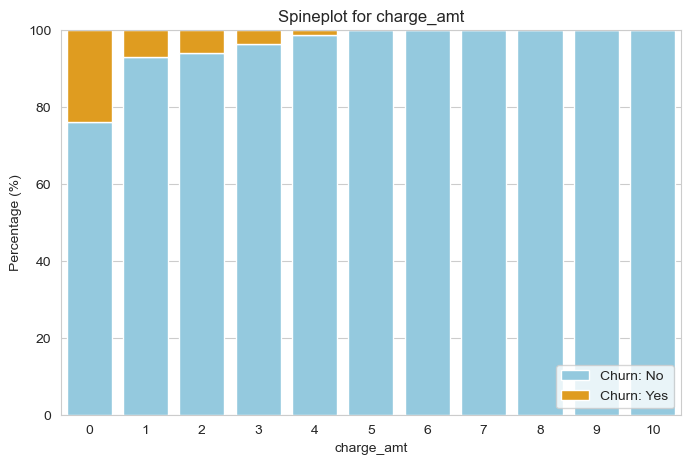

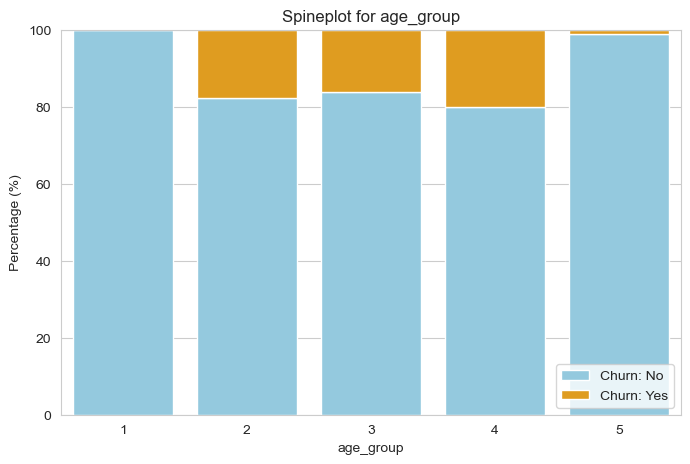

In [27]:
# Spineplots for the ordinal vs. binary data
for var in category_X.columns:
    # Number of unique categories in the variable
    num_categories = len(np.unique(category_X[var]))
    
    # Skip the variable if it has 2 or fewer unique categories
    if num_categories <= 2:
        continue
    
    # Create a new DataFrame for plotting
    plot_data = pd.DataFrame({
        var: category_X[var],
        'churn': category['churn']
    })

    # Calculate percentages
    plot_data['count'] = 1
    plot_data = plot_data.groupby([var, 'churn']).count().unstack().fillna(0)
    plot_data_percentage = plot_data.div(plot_data.sum(axis=1), axis=0) * 100
    
    # Resetting index for the merge operation
    plot_data_percentage.reset_index(inplace=True)

    # Plotting
    plt.figure(figsize=(8, 5))
    sns.barplot(data=plot_data_percentage, x=var, y=('count', 0), color='skyblue', label='Churn: No')
    sns.barplot(data=plot_data_percentage, x=var, y=('count', 1), color='orange', label='Churn: Yes', bottom=plot_data_percentage[('count', 0)])
    
    plt.ylabel('Percentage (%)')
    plt.title(f'Spineplot for {var}')
    plt.legend(loc='lower right')
    
    plt.show()
    print('\n')